In [1]:
import pennylane as qml
from pennylane import numpy as np

import time


# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# GPUs

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(0, 8)))

# jax.local_device_count() 
jax.devices()

[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0)]

In [2]:
device_type = "default.qubit"

# device_type = "lightning.gpu"

device = qml.device(device_type, wires=20)

device

<DefaultQubit device (wires=20, shots=None) at 0x7fe420337a30>

In [3]:
def circuit(param):
    
    qml.RX(param, wires=0)
    qml.CNOT(wires=[0, 3])

    return qml.expval(qml.PauliZ(0))

In [4]:
jax_circuit = qml.QNode(circuit, device, interface="jax")

jax_circuit

<QNode: wires=20, device='default.qubit.jax', interface='jax', diff_method='best'>

In [7]:
vmap_circuit = jax.vmap(jax_circuit)

vmap_circuit

<function __main__.circuit(param)>

In [11]:
batch_params = jnp.array([1.02, 0.123, -0.571])

batch_params

DeviceArray([ 1.02 ,  0.123, -0.571], dtype=float64)

In [12]:
batched_results = vmap_circuit(batch_params).block_until_ready()

batched_results

DeviceArray([0.52336595, 0.99244503, 0.84136092], dtype=float64)

In [15]:
batched_parameters = jnp.array([0.123] * 300)

len(batched_parameters)

300

In [17]:
start_time = time.time()

batched_results = vmap_circuit(batched_parameters).block_until_ready()

execution_time = time.time() - start_time

execution_time

0.17595362663269043

In [18]:
start_time = time.time()

for parameter in batched_parameters:
    
    jax_circuit(parameter).block_until_ready()
    
execution_time = time.time() - start_time

execution_time

5.799076557159424

# 101 Tutorial

In [32]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float64)

In [33]:
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49]], requires_grad=True)

In [34]:
ws

tensor([[2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.]], requires_grad=True)

In [35]:
jax.vmap(convolve)(xs, ws)

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.],
             [371., 380., 389.],
             [416., 425., 434.]], dtype=float64)

In [43]:
jax.pmap(convolve)(xs, ws)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.],
                    [371., 380., 389.],
                    [416., 425., 434.]], dtype=float64)

In [46]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.],
                    [46758., 47898., 49038.],
                    [58668., 59943., 61218.]], dtype=float64)

In [47]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.],
                    [371., 380., 389.],
                    [416., 425., 434.]], dtype=float64)

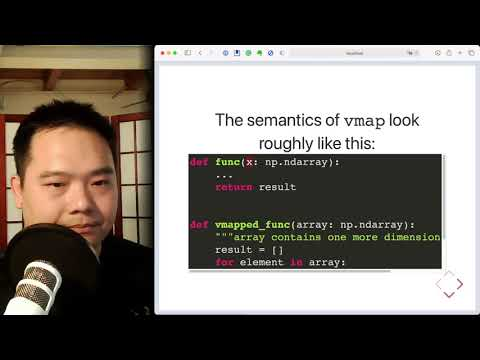

In [48]:
from IPython.display import YouTubeVideo, display

YouTubeVideo("YB74pwPyAT0")